# Import Libraries and Define Nested CV Function for Each Algorithm

In [1]:
## Import libraries
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import regex as re
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.svm import SVC, NuSVC
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedKFold
from sklearn.naive_bayes import GaussianNB
from lightgbm import LGBMClassifier
from numpy import mean
from numpy import std
from sklearn.feature_selection import SelectFromModel
import math
import seaborn as sns
import shap
from matplotlib import pyplot as plt
%matplotlib inline

import joblib

In [2]:
## No warnings!
import warnings
warnings.filterwarnings('ignore')

In [3]:
'''
Function: random_forest_grid

Purpose: Performing hyperparameter search for random forest classifier using 5X nested 5-fold Cross Validation.

Input: X and y (Features and Outcome)

Output: Results of the hyperparameter GridSearchCV, shap values for each sample, 
'''

def random_forest_grid(X, y, feature_names):
    
    ## Initialize SHAP JS
    shap.initjs()

    # configure the cross-validation procedure
    cv_outer = KFold(n_splits=6, random_state=27, shuffle=True)
    
    ## Initiate CV round variable
    cv_round = 0

    
    # enumerate splits
    outer_results_accuracy = list()
    outer_results_precision = list()
    outer_results_recall = list()
    outer_results_f1 = list()
    outer_results_roc = list()

    ## Make dictionary to store shap values
    shap_values_per_sample = dict()
    for sample in range(len(X)):
        
        ## Create keys for each sample
        shap_values_per_sample[sample] = {} 
        shap_values_per_sample[sample][0] = {}
        shap_values_per_sample[sample][1] = {}
        shap_values_per_sample[sample][2] = {}

        
    ## Make list to store variable names
    variable_names = []

    
    # perform cross-validation procedure
    for train_ix, test_ix in cv_outer.split(X):

        # split data
        X_train, X_test = X[train_ix, :], X[test_ix, :]
        y_train, y_test = y[train_ix], y[test_ix]
        
        # configure the cross-validation procedure
        cv_inner = KFold(n_splits=3, random_state=27, shuffle=True)
    
        pipeline = Pipeline(

        [
         ('selector', SelectFromModel(estimator=RandomForestClassifier(random_state=27))),
         ('model', RandomForestClassifier(random_state=27))
        ]
        )
        
        search = GridSearchCV(
        estimator = pipeline,
        param_grid = {
          'selector__max_features': np.arange(6, 13, 2),
          'model__min_samples_leaf':np.arange(1, 13, 2),
          'model__criterion':["gini","entropy"],
          'model__n_estimators':np.arange(10, 101, 20),
          'model__bootstrap':[True, False]        
         },
        n_jobs=-1,
        scoring="roc_auc",
        cv=cv_inner,
        verbose=3
        )
        
        
        # execute search
        result = search.fit(X_train, y_train)   
        
        ## Only keep selected features
        features_mask = result.best_estimator_.named_steps['selector'].get_support()
        X_train_selected = X_train[:, features_mask.astype(bool)].copy()
        X_test_selected = X_test[:, features_mask.astype(bool)].copy()
        
        ## Create list of features in this model
        feature_names_this_round = feature_names[features_mask.astype(bool)].copy()
        variable_names += feature_names_this_round.tolist()
        

        # get the best performing model fit on the whole training set
        best_model = result.best_estimator_
        

        ## Use SHAP to explain predictions using best model
        explainer = shap.KernelExplainer(best_model._final_estimator.predict, X_train_selected) 
        shap_values = explainer.shap_values(X_test_selected)
        
        # Extract SHAP information per fold per sample 
        for i, test_index in enumerate(test_ix):
            shap_values_per_sample[test_index][0] = shap_values[i] 
            shap_values_per_sample[test_index][1] = feature_names_this_round
            shap_values_per_sample[test_index][2] = cv_round
            
        cv_round += 1
        
        # evaluate model on the hold out dataset
        yhat = best_model._final_estimator.predict(X_test_selected)
        
        print("y_hat")

        # evaluate the model
        accuracy = accuracy_score(y_test, yhat)
        precision = precision_score(y_test, yhat)
        recall = recall_score(y_test, yhat)
        f1 = f1_score(y_test, yhat)
        roc= roc_auc_score(y_test, yhat)
        
        # store the result
        outer_results_accuracy.append(accuracy)
        outer_results_precision.append(precision)
        outer_results_recall.append(recall)
        outer_results_f1.append(f1)
        outer_results_roc.append(roc)


        # report progress
        print('>acc=%.3f, >precision=%.3f, >recall=%.3f, >f1=%.3f, >roc_auc=%.3f, est=%.3f, cfg=%s' % (accuracy, precision, recall, f1, roc, result.best_score_, result.best_params_))

    # summarize the estimated performance of the model
    print("\n\n")
    print('Accuracy: %.3f (%.3f)' % (mean(outer_results_accuracy), std(outer_results_accuracy)))
    print('Precision: %.3f (%.3f)' % (mean(outer_results_precision), std(outer_results_precision)))
    print('Recall: %.3f (%.3f)' % (mean(outer_results_recall), std(outer_results_recall)))
    print('F1: %.3f (%.3f)' % (mean(outer_results_f1), std(outer_results_f1)))
    print('ROC-AUC: %.3f (%.3f)' % (mean(outer_results_roc), std(outer_results_roc)))


    return search, shap_values_per_sample, variable_names

In [4]:
'''
Function: logistic_regression_grid

Purpose: Performing hyperparameter search for logistic regression classifier using 5X nested 5-fold Cross Validation.

Input: X and y (Features and Outcome)

Output: Results of the hyperparameter GridSearchCV
'''

def logistic_regression_grid(X, y, feature_names):
    
    
    ## Initialize SHAP JS
    shap.initjs()

    # configure the cross-validation procedure
    cv_outer = KFold(n_splits=6, random_state=27, shuffle=True)
    
    ## Initiate CV round variable
    cv_round = 0

    
    # enumerate splits
    outer_results_accuracy = list()
    outer_results_precision = list()
    outer_results_recall = list()
    outer_results_f1 = list()
    outer_results_roc = list()

    ## Make dictionary to store shap values
    shap_values_per_sample = dict()
    for sample in range(len(X)):
        
        ## Create keys for each sample
        shap_values_per_sample[sample] = {} 
        shap_values_per_sample[sample][0] = {}
        shap_values_per_sample[sample][1] = {}
        shap_values_per_sample[sample][2] = {}

        
    ## Make list to store variable names
    variable_names = []
    
    # perform cross-validation procedure
    for train_ix, test_ix in cv_outer.split(X):
        
        # split data
        X_train, X_test = X[train_ix, :], X[test_ix, :]
        y_train, y_test = y[train_ix], y[test_ix]
        
        # configure the cross-validation procedure
        cv_inner = KFold(n_splits=3, random_state=27, shuffle=True)
    
        pipeline = Pipeline(
        [
         ('selector', SelectFromModel(estimator=RandomForestClassifier(random_state=27))),
         ('model', LogisticRegression(random_state=27, max_iter=10000))
        ]
        )

        search = GridSearchCV(
        estimator = pipeline,
        param_grid = {
          'selector__max_features': np.arange(6, 13, 2),
          'model__penalty':["elasticnet"],
          'model__C':np.arange(0.01, 1.01, 0.05),
          'model__l1_ratio': np.arange(0.1, 1, 0.2),
          'model__solver':['saga'],
          'model__fit_intercept':[True, False]        
         },
        n_jobs=-1,
        scoring="roc_auc",
        cv=cv_inner,
        verbose=3
        )

    
        # execute search
        result = search.fit(X_train, y_train)   
        
        ## Only keep selected features
        features_mask = result.best_estimator_.named_steps['selector'].get_support()
        X_train_selected = X_train[:, features_mask.astype(bool)].copy()
        X_test_selected = X_test[:, features_mask.astype(bool)].copy()
        
        ## Create list of features in this model
        feature_names_this_round = feature_names[features_mask.astype(bool)].copy()
        variable_names += feature_names_this_round.tolist()
        

        # get the best performing model fit on the whole training set
        best_model = result.best_estimator_
        

        ## Use SHAP to explain predictions using best model
        explainer = shap.KernelExplainer(best_model._final_estimator.predict, X_train_selected) 
        shap_values = explainer.shap_values(X_test_selected)
        
        # Extract SHAP information per fold per sample 
        for i, test_index in enumerate(test_ix):
            shap_values_per_sample[test_index][0] = shap_values[i] 
            shap_values_per_sample[test_index][1] = feature_names_this_round
            shap_values_per_sample[test_index][2] = cv_round
            
        cv_round += 1
        
        # evaluate model on the hold out dataset
        yhat = best_model._final_estimator.predict(X_test_selected)
        
        print("y_hat")

        # evaluate the model
        accuracy = accuracy_score(y_test, yhat)
        precision = precision_score(y_test, yhat)
        recall = recall_score(y_test, yhat)
        f1 = f1_score(y_test, yhat)
        roc= roc_auc_score(y_test, yhat)
        
        # store the result
        outer_results_accuracy.append(accuracy)
        outer_results_precision.append(precision)
        outer_results_recall.append(recall)
        outer_results_f1.append(f1)
        outer_results_roc.append(roc)


        # report progress
        print('>acc=%.3f, >precision=%.3f, >recall=%.3f, >f1=%.3f, >roc_auc=%.3f, est=%.3f, cfg=%s' % (accuracy, precision, recall, f1, roc, result.best_score_, result.best_params_))

    # summarize the estimated performance of the model
    print("\n\n")
    print('Accuracy: %.3f (%.3f)' % (mean(outer_results_accuracy), std(outer_results_accuracy)))
    print('Precision: %.3f (%.3f)' % (mean(outer_results_precision), std(outer_results_precision)))
    print('Recall: %.3f (%.3f)' % (mean(outer_results_recall), std(outer_results_recall)))
    print('F1: %.3f (%.3f)' % (mean(outer_results_f1), std(outer_results_f1)))
    print('ROC-AUC: %.3f (%.3f)' % (mean(outer_results_roc), std(outer_results_roc)))


    return search, shap_values_per_sample, variable_names

In [5]:
'''
Function: support_vector_machine_grid

Purpose: Performing hyperparameter search for support vector machine classifier using 5X nested 5-fold Cross Validation.

Input: X and y (Features and Outcome)

Output: Results of the hyperparameter GridSearchCV
'''

def support_vector_machine_grid(X, y, feature_names):
    
    ## Initialize SHAP JS
    shap.initjs()

    # configure the cross-validation procedure
    cv_outer = KFold(n_splits=6, random_state=27, shuffle=True)
    
    ## Initiate CV round variable
    cv_round = 0

    
    # enumerate splits
    outer_results_accuracy = list()
    outer_results_precision = list()
    outer_results_recall = list()
    outer_results_f1 = list()
    outer_results_roc = list()

    ## Make dictionary to store shap values
    shap_values_per_sample = dict()
    for sample in range(len(X)):
        
        ## Create keys for each sample
        shap_values_per_sample[sample] = {} 
        shap_values_per_sample[sample][0] = {}
        shap_values_per_sample[sample][1] = {}
        shap_values_per_sample[sample][2] = {}

        
    ## Make list to store variable names
    variable_names = []
    
    # perform cross-validation procedure
    for train_ix, test_ix in cv_outer.split(X):
        
        # split data
        X_train, X_test = X[train_ix, :], X[test_ix, :]
        y_train, y_test = y[train_ix], y[test_ix]
        
        # configure the cross-validation procedure
        cv_inner = KFold(n_splits=3, random_state=27, shuffle=True)
    
        pipeline = Pipeline(
        [
         ('selector', SelectFromModel(estimator=RandomForestClassifier(random_state=27))),
         ('model', SVC(random_state=27))
        ]
        )

        search = GridSearchCV(
        estimator = pipeline,
        param_grid = {
          'selector__max_features': np.arange(6, 13, 2),
          'model__gamma': ['scale', 'auto'],
          'model__C': np.arange(0.01, 1.001, 0.05),
          'model__kernel': ['linear', 'rbf'],
         },
        n_jobs=-1,
        scoring="roc_auc",
        cv=cv_inner,
        verbose=3
        )
    
        # execute search
        result = search.fit(X_train, y_train)   
        
        ## Only keep selected features
        features_mask = result.best_estimator_.named_steps['selector'].get_support()
        X_train_selected = X_train[:, features_mask.astype(bool)].copy()
        X_test_selected = X_test[:, features_mask.astype(bool)].copy()
        
        ## Create list of features in this model
        feature_names_this_round = feature_names[features_mask.astype(bool)].copy()
        variable_names += feature_names_this_round.tolist()
        

        # get the best performing model fit on the whole training set
        best_model = result.best_estimator_
        

        ## Use SHAP to explain predictions using best model
        explainer = shap.KernelExplainer(best_model._final_estimator.predict, X_train_selected) 
        shap_values = explainer.shap_values(X_test_selected)
        
        # Extract SHAP information per fold per sample 
        for i, test_index in enumerate(test_ix):
            shap_values_per_sample[test_index][0] = shap_values[i] 
            shap_values_per_sample[test_index][1] = feature_names_this_round
            shap_values_per_sample[test_index][2] = cv_round
            
        cv_round += 1
        
        # evaluate model on the hold out dataset
        yhat = best_model._final_estimator.predict(X_test_selected)
        
        print("y_hat")

        # evaluate the model
        accuracy = accuracy_score(y_test, yhat)
        precision = precision_score(y_test, yhat)
        recall = recall_score(y_test, yhat)
        f1 = f1_score(y_test, yhat)
        roc= roc_auc_score(y_test, yhat)
        
        # store the result
        outer_results_accuracy.append(accuracy)
        outer_results_precision.append(precision)
        outer_results_recall.append(recall)
        outer_results_f1.append(f1)
        outer_results_roc.append(roc)


        # report progress
        print('>acc=%.3f, >precision=%.3f, >recall=%.3f, >f1=%.3f, >roc_auc=%.3f, est=%.3f, cfg=%s' % (accuracy, precision, recall, f1, roc, result.best_score_, result.best_params_))

    # summarize the estimated performance of the model
    print("\n\n")
    print('Accuracy: %.3f (%.3f)' % (mean(outer_results_accuracy), std(outer_results_accuracy)))
    print('Precision: %.3f (%.3f)' % (mean(outer_results_precision), std(outer_results_precision)))
    print('Recall: %.3f (%.3f)' % (mean(outer_results_recall), std(outer_results_recall)))
    print('F1: %.3f (%.3f)' % (mean(outer_results_f1), std(outer_results_f1)))
    print('ROC-AUC: %.3f (%.3f)' % (mean(outer_results_roc), std(outer_results_roc)))


    return search, shap_values_per_sample, variable_names

In [6]:
'''
Function: KNN_grid

Purpose: Performing hyperparameter search for K-Nearest Neighbors classifier using 5X nested 5-fold Cross Validation.

Input: X and y (Features and Outcome)

Output: Results of the hyperparameter GridSearchCV
'''

def KNN_grid(X, y, feature_names):
    
    ## Initialize SHAP JS
    shap.initjs()

    # configure the cross-validation procedure
    cv_outer = KFold(n_splits=6, random_state=27, shuffle=True)
    
    ## Initiate CV round variable
    cv_round = 0

    
    # enumerate splits
    outer_results_accuracy = list()
    outer_results_precision = list()
    outer_results_recall = list()
    outer_results_f1 = list()
    outer_results_roc = list()

    ## Make dictionary to store shap values
    shap_values_per_sample = dict()
    for sample in range(len(X)):
        
        ## Create keys for each sample
        shap_values_per_sample[sample] = {} 
        shap_values_per_sample[sample][0] = {}
        shap_values_per_sample[sample][1] = {}
        shap_values_per_sample[sample][2] = {}

        
    ## Make list to store variable names
    variable_names = []
    
    
    # perform cross-validation procedure
    for train_ix, test_ix in cv_outer.split(X):
        
        # split data
        X_train, X_test = X[train_ix, :], X[test_ix, :]
        y_train, y_test = y[train_ix], y[test_ix]
        
        # configure the cross-validation procedure
        cv_inner = KFold(n_splits=3, random_state=27, shuffle=True)
    
    
        pipeline = Pipeline(
        [
         ('selector', SelectFromModel(estimator=RandomForestClassifier(random_state=27))),
         ('model', KNeighborsClassifier())
        ]
        )

        search = GridSearchCV(
        estimator = pipeline,
        param_grid = {
          'selector__max_features': np.arange(6, 13, 2),
          'model__n_neighbors':np.arange(1, 30, 5),
          'model__weights':["uniform","distance"],
          'model__leaf_size':np.arange(1, 33, 6),
          'model__p':[1, 2]        
         },
        n_jobs=-1,
        scoring="roc_auc",
        cv=cv_inner,
        verbose=3
        )
        
        # execute search
        result = search.fit(X_train, y_train)   
        
        ## Only keep selected features
        features_mask = result.best_estimator_.named_steps['selector'].get_support()
        X_train_selected = X_train[:, features_mask.astype(bool)].copy()
        X_test_selected = X_test[:, features_mask.astype(bool)].copy()
        
        ## Create list of features in this model
        feature_names_this_round = feature_names[features_mask.astype(bool)].copy()
        variable_names += feature_names_this_round.tolist()
        

        # get the best performing model fit on the whole training set
        best_model = result.best_estimator_
        

        ## Use SHAP to explain predictions using best model
        explainer = shap.KernelExplainer(best_model._final_estimator.predict, X_train_selected) 
        shap_values = explainer.shap_values(X_test_selected)
        
        # Extract SHAP information per fold per sample 
        for i, test_index in enumerate(test_ix):
            shap_values_per_sample[test_index][0] = shap_values[i] 
            shap_values_per_sample[test_index][1] = feature_names_this_round
        
        # evaluate model on the hold out dataset
        yhat = best_model._final_estimator.predict(X_test_selected)
        
        print("y_hat")

        # evaluate the model
        accuracy = accuracy_score(y_test, yhat)
        precision = precision_score(y_test, yhat)
        recall = recall_score(y_test, yhat)
        f1 = f1_score(y_test, yhat)
        roc= roc_auc_score(y_test, yhat)
        
        # store the result
        outer_results_accuracy.append(accuracy)
        outer_results_precision.append(precision)
        outer_results_recall.append(recall)
        outer_results_f1.append(f1)
        outer_results_roc.append(roc)


        # report progress
        print('>acc=%.3f, >precision=%.3f, >recall=%.3f, >f1=%.3f, >roc_auc=%.3f, est=%.3f, cfg=%s' % (accuracy, precision, recall, f1, roc, result.best_score_, result.best_params_))

    # summarize the estimated performance of the model
    print("\n\n")
    print('Accuracy: %.3f (%.3f)' % (mean(outer_results_accuracy), std(outer_results_accuracy)))
    print('Precision: %.3f (%.3f)' % (mean(outer_results_precision), std(outer_results_precision)))
    print('Recall: %.3f (%.3f)' % (mean(outer_results_recall), std(outer_results_recall)))
    print('F1: %.3f (%.3f)' % (mean(outer_results_f1), std(outer_results_f1)))
    print('ROC-AUC: %.3f (%.3f)' % (mean(outer_results_roc), std(outer_results_roc)))


    return search, shap_values_per_sample, variable_names

In [7]:
'''
Function: naive_bayes_grid

Purpose: Performing hyperparameter search for Naive Bayes classifier using 5X nested 5-fold Cross Validation.

Input: X and y (Features and Outcome)

Output: Results of the hyperparameter GridSearchCV
'''

def naive_bayes_grid(X, y, feature_names):
    
    ## Initialize SHAP JS
    shap.initjs()

    # configure the cross-validation procedure
    cv_outer = KFold(n_splits=6, random_state=27, shuffle=True)
    
    ## Initiate CV round variable
    cv_round = 0

    
    # enumerate splits
    outer_results_accuracy = list()
    outer_results_precision = list()
    outer_results_recall = list()
    outer_results_f1 = list()
    outer_results_roc = list()

    ## Make dictionary to store shap values
    shap_values_per_sample = dict()
    for sample in range(len(X)):
        
        ## Create keys for each sample
        shap_values_per_sample[sample] = {} 
        shap_values_per_sample[sample][0] = {}
        shap_values_per_sample[sample][1] = {}
        shap_values_per_sample[sample][2] = {}

        
    ## Make list to store variable names
    variable_names = []

    
    
    # perform cross-validation procedure
    for train_ix, test_ix in cv_outer.split(X):
        
        # split data
        X_train, X_test = X[train_ix, :], X[test_ix, :]
        y_train, y_test = y[train_ix], y[test_ix]
        
        # configure the cross-validation procedure
        cv_inner = KFold(n_splits=3, random_state=27, shuffle=True)
    

        pipeline = Pipeline(
        [
         ('selector', SelectFromModel(estimator=RandomForestClassifier(random_state=27))),
         ('model', GaussianNB())
        ]
        )

        search = GridSearchCV(
        estimator = pipeline,
        param_grid = {
          'selector__max_features': np.arange(6, 13, 2),
          'model__var_smoothing': np.logspace(0,-11, num=150)    
         },
        n_jobs=-1,
        scoring="roc_auc",
        cv=cv_inner,
        verbose=3
        )

        # execute search
        result = search.fit(X_train, y_train)   
        
        ## Only keep selected features
        features_mask = result.best_estimator_.named_steps['selector'].get_support()
        X_train_selected = X_train[:, features_mask.astype(bool)].copy()
        X_test_selected = X_test[:, features_mask.astype(bool)].copy()
        
        ## Create list of features in this model
        feature_names_this_round = feature_names[features_mask.astype(bool)].copy()
        variable_names += feature_names_this_round.tolist()
        

        # get the best performing model fit on the whole training set
        best_model = result.best_estimator_
        

        ## Use SHAP to explain predictions using best model
        explainer = shap.KernelExplainer(best_model._final_estimator.predict, X_train_selected) 
        shap_values = explainer.shap_values(X_test_selected)
        
        # Extract SHAP information per fold per sample 
        for i, test_index in enumerate(test_ix):
            shap_values_per_sample[test_index][0] = shap_values[i] 
            shap_values_per_sample[test_index][1] = feature_names_this_round
            shap_values_per_sample[test_index][2] = cv_round
            
        cv_round += 1
        
        # evaluate model on the hold out dataset
        yhat = best_model._final_estimator.predict(X_test_selected)
        
        print("y_hat")

        # evaluate the model
        accuracy = accuracy_score(y_test, yhat)
        precision = precision_score(y_test, yhat)
        recall = recall_score(y_test, yhat)
        f1 = f1_score(y_test, yhat)
        roc= roc_auc_score(y_test, yhat)
        
        # store the result
        outer_results_accuracy.append(accuracy)
        outer_results_precision.append(precision)
        outer_results_recall.append(recall)
        outer_results_f1.append(f1)
        outer_results_roc.append(roc)


        # report progress
        print('>acc=%.3f, >precision=%.3f, >recall=%.3f, >f1=%.3f, >roc_auc=%.3f, est=%.3f, cfg=%s' % (accuracy, precision, recall, f1, roc, result.best_score_, result.best_params_))

    # summarize the estimated performance of the model
    print("\n\n")
    print('Accuracy: %.3f (%.3f)' % (mean(outer_results_accuracy), std(outer_results_accuracy)))
    print('Precision: %.3f (%.3f)' % (mean(outer_results_precision), std(outer_results_precision)))
    print('Recall: %.3f (%.3f)' % (mean(outer_results_recall), std(outer_results_recall)))
    print('F1: %.3f (%.3f)' % (mean(outer_results_f1), std(outer_results_f1)))
    print('ROC-AUC: %.3f (%.3f)' % (mean(outer_results_roc), std(outer_results_roc)))


    return search, shap_values_per_sample, variable_names

In [8]:
'''
Function: light_gbm_grid

Purpose: Performing hyperparameter search for Light Gradient Boosting classifier using 5X nested 5-fold Cross Validation.

Input: X and y (Features and Outcome)

Output: Results of the hyperparameter GridSearchCV
'''

def light_gbm_grid(X, y, feature_names):
    
    ## Initialize SHAP JS
    shap.initjs()

    # configure the cross-validation procedure
    cv_outer = KFold(n_splits=6, random_state=27, shuffle=True)
    
    ## Initiate CV round variable
    cv_round = 0

    
    # enumerate splits
    outer_results_accuracy = list()
    outer_results_precision = list()
    outer_results_recall = list()
    outer_results_f1 = list()
    outer_results_roc = list()

    ## Make dictionary to store shap values
    shap_values_per_sample = dict()
    for sample in range(len(X)):
        
        ## Create keys for each sample
        shap_values_per_sample[sample] = {} 
        shap_values_per_sample[sample][0] = {}
        shap_values_per_sample[sample][1] = {}
        shap_values_per_sample[sample][2] = {}

        
    ## Make list to store variable names
    variable_names = []

    
    
    # perform cross-validation procedure
    for train_ix, test_ix in cv_outer.split(X):
        
        # split data
        X_train, X_test = X[train_ix, :], X[test_ix, :]
        y_train, y_test = y[train_ix], y[test_ix]
        
        # configure the cross-validation procedure
        cv_inner = KFold(n_splits=3, random_state=27, shuffle=True)
    
    
        pipeline = Pipeline(
        [
         ('selector', SelectFromModel(estimator=RandomForestClassifier(random_state=27))),
         ('model', LGBMClassifier(random_state=27))
        ]
        )

        search = GridSearchCV(
        estimator = pipeline,
        param_grid = {
          'selector__max_features': np.arange(6, 13, 2),
          'model__n_estimators': [50, 100],
          'model__learning_rate': [0.005, 0.01, 0.1, 0.3],
          'model__num_leaves': [5, 10, 20],
          'model__min_child_samples':[5, 10, 20],
          'model__max_bin': [20, 50]
         },
        n_jobs=-1,
        scoring="roc_auc",
        cv=cv_inner,
        verbose=3
        )

        # execute search
        result = search.fit(X_train, y_train)   
        
        ## Only keep selected features
        features_mask = result.best_estimator_.named_steps['selector'].get_support()
        X_train_selected = X_train[:, features_mask.astype(bool)].copy()
        X_test_selected = X_test[:, features_mask.astype(bool)].copy()
        
        ## Create list of features in this model
        feature_names_this_round = feature_names[features_mask.astype(bool)].copy()
        variable_names += feature_names_this_round.tolist()
        

        # get the best performing model fit on the whole training set
        best_model = result.best_estimator_
        

        ## Use SHAP to explain predictions using best model
        explainer = shap.KernelExplainer(best_model._final_estimator.predict, X_train_selected) 
        shap_values = explainer.shap_values(X_test_selected)
        
        # Extract SHAP information per fold per sample 
        for i, test_index in enumerate(test_ix):
            shap_values_per_sample[test_index][0] = shap_values[i] 
            shap_values_per_sample[test_index][1] = feature_names_this_round
            shap_values_per_sample[test_index][2] = cv_round
            
        cv_round += 1
        
        # evaluate model on the hold out dataset
        yhat = best_model._final_estimator.predict(X_test_selected)
        
        print("y_hat")

        # evaluate the model
        accuracy = accuracy_score(y_test, yhat)
        precision = precision_score(y_test, yhat)
        recall = recall_score(y_test, yhat)
        f1 = f1_score(y_test, yhat)
        roc= roc_auc_score(y_test, yhat)
        
        # store the result
        outer_results_accuracy.append(accuracy)
        outer_results_precision.append(precision)
        outer_results_recall.append(recall)
        outer_results_f1.append(f1)
        outer_results_roc.append(roc)


        # report progress
        print('>acc=%.3f, >precision=%.3f, >recall=%.3f, >f1=%.3f, >roc_auc=%.3f, est=%.3f, cfg=%s' % (accuracy, precision, recall, f1, roc, result.best_score_, result.best_params_))

    # summarize the estimated performance of the model
    print("\n\n")
    print('Accuracy: %.3f (%.3f)' % (mean(outer_results_accuracy), std(outer_results_accuracy)))
    print('Precision: %.3f (%.3f)' % (mean(outer_results_precision), std(outer_results_precision)))
    print('Recall: %.3f (%.3f)' % (mean(outer_results_recall), std(outer_results_recall)))
    print('F1: %.3f (%.3f)' % (mean(outer_results_f1), std(outer_results_f1)))
    print('ROC-AUC: %.3f (%.3f)' % (mean(outer_results_roc), std(outer_results_roc)))


    return search, shap_values_per_sample, variable_names

# Import data, run nested cross validation, and save results

In [9]:
## Open the excel file
name= "../data/two_outcomes/undersampled_dataset.csv"
df = pd.read_csv(name)

In [10]:
## Rename columns

df.rename(columns={'ASI_Drugs': "ASI-6 Drug-related problems score", 'ASI_Psychiatric':"ASI-6 Psychiatric-related problems score", 
    'D_AlcDrugsNumberTreatments': "ASI-6 Number of drug/alcohol related treatments underwent",
    'D_NicotineRegAbuseRatio': "ASI-6 Ratio between age and years of regular use of nicotine",
    'D_DrugEverCrave': "ASI-6 Drug-related craving symptoms last 30 days before treatment", 
    'T_CTQ': "CTQ Total score" , 'CSSA1.TOTAL': "CSSA Score first week of treatment",
    'D_Crack_30Days': "ASI-6 Days consuming crack the last month before detoxification",
    'ASI_FamilySocialProblem': "ASI-6 Family and social related problems score",
    'T_EmotionalAbuse_CTQ': "CTQ Emotional abuse subscore", 
    'T_EmotinalNeglect_CTQ': "CTQ Emotional neglect subscore",
    'D_CrackCocaine_30Days': "ASI-6 Days consuming crack or cocaine the last month before detoxification",
    'D_DrugUse_30Days': "ASI-6 Days consuming drugs in the last month before detoxification",
     'E_ControlledEnvironment_30Days': "ASI-6 Anytime in controlled environment last 30 days before treatment", 
     'D_CannabisRegAbuseRatio': "ASI-6 Ratio between age and years of regular use of cannabis",
       'T_SexualAbuse_CTQ': "CTQ Sexual abuse subscore"}, inplace=True)

In [11]:
## Split X and y
X_original = df.drop(['outcome'], axis=1, inplace=False)
y = df["outcome"]

In [12]:
## Make numpy array of dataframe
X = X_original.to_numpy(copy=True)

## Create scaled features
X_scaled = StandardScaler().fit_transform(X)


## Create feature names list
feature_names = np.asarray(X_original.columns)

In [13]:
## Perform hyperparameter search for random forest
search_rf, shap_values_rf, variable_names_rf = random_forest_grid(X, y, feature_names)

## Save best random forest classifier model for future usage
joblib.dump(search_rf.best_estimator_, '../top_models/best_random_forest.pkl')

Fitting 3 folds for each of 480 candidates, totalling 1440 fits


Using 236 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/48 [00:00<?, ?it/s]

y_hat
>acc=0.708, >precision=0.800, >recall=0.615, >f1=0.696, >roc_auc=0.717, est=0.731, cfg={'model__bootstrap': False, 'model__criterion': 'entropy', 'model__min_samples_leaf': 3, 'model__n_estimators': 10, 'selector__max_features': 10}
Fitting 3 folds for each of 480 candidates, totalling 1440 fits


Using 236 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/48 [00:00<?, ?it/s]

y_hat
>acc=0.667, >precision=0.667, >recall=0.769, >f1=0.714, >roc_auc=0.657, est=0.799, cfg={'model__bootstrap': True, 'model__criterion': 'entropy', 'model__min_samples_leaf': 11, 'model__n_estimators': 10, 'selector__max_features': 10}
Fitting 3 folds for each of 480 candidates, totalling 1440 fits


Using 237 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/47 [00:00<?, ?it/s]

y_hat
>acc=0.660, >precision=0.636, >recall=0.636, >f1=0.636, >roc_auc=0.658, est=0.764, cfg={'model__bootstrap': True, 'model__criterion': 'entropy', 'model__min_samples_leaf': 7, 'model__n_estimators': 90, 'selector__max_features': 10}
Fitting 3 folds for each of 480 candidates, totalling 1440 fits


Using 237 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/47 [00:00<?, ?it/s]

y_hat
>acc=0.681, >precision=0.688, >recall=0.524, >f1=0.595, >roc_auc=0.666, est=0.724, cfg={'model__bootstrap': True, 'model__criterion': 'gini', 'model__min_samples_leaf': 11, 'model__n_estimators': 10, 'selector__max_features': 8}
Fitting 3 folds for each of 480 candidates, totalling 1440 fits


Using 237 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/47 [00:00<?, ?it/s]

y_hat
>acc=0.617, >precision=0.630, >recall=0.680, >f1=0.654, >roc_auc=0.613, est=0.739, cfg={'model__bootstrap': True, 'model__criterion': 'entropy', 'model__min_samples_leaf': 11, 'model__n_estimators': 30, 'selector__max_features': 12}
Fitting 3 folds for each of 480 candidates, totalling 1440 fits


Using 237 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/47 [00:00<?, ?it/s]

y_hat
>acc=0.681, >precision=0.621, >recall=0.818, >f1=0.706, >roc_auc=0.689, est=0.741, cfg={'model__bootstrap': True, 'model__criterion': 'entropy', 'model__min_samples_leaf': 11, 'model__n_estimators': 90, 'selector__max_features': 6}



Accuracy: 0.669 (0.028)
Precision: 0.673 (0.061)
Recall: 0.674 (0.098)
F1: 0.667 (0.043)
ROC-AUC: 0.667 (0.032)


['../top_models/best_random_forest.pkl']

In [14]:
## Perform hyperparameter search for random forest
search_logreg, shap_values_logreg, variable_names_logreg = logistic_regression_grid(X, y, feature_names)

## Save best random forest classifier model for future usage
joblib.dump(search_logreg.best_estimator_, '../top_models/best_logistic_regression.pkl')

Fitting 3 folds for each of 800 candidates, totalling 2400 fits


Using 236 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/48 [00:00<?, ?it/s]

y_hat
>acc=0.750, >precision=0.769, >recall=0.769, >f1=0.769, >roc_auc=0.748, est=0.722, cfg={'model__C': 0.01, 'model__fit_intercept': True, 'model__l1_ratio': 0.9000000000000001, 'model__penalty': 'elasticnet', 'model__solver': 'saga', 'selector__max_features': 8}
Fitting 3 folds for each of 800 candidates, totalling 2400 fits


Using 236 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/48 [00:00<?, ?it/s]

y_hat
>acc=0.667, >precision=0.667, >recall=0.769, >f1=0.714, >roc_auc=0.657, est=0.773, cfg={'model__C': 0.31000000000000005, 'model__fit_intercept': True, 'model__l1_ratio': 0.7000000000000001, 'model__penalty': 'elasticnet', 'model__solver': 'saga', 'selector__max_features': 8}
Fitting 3 folds for each of 800 candidates, totalling 2400 fits


Using 237 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/47 [00:00<?, ?it/s]

y_hat
>acc=0.638, >precision=0.600, >recall=0.682, >f1=0.638, >roc_auc=0.641, est=0.756, cfg={'model__C': 0.01, 'model__fit_intercept': False, 'model__l1_ratio': 0.9000000000000001, 'model__penalty': 'elasticnet', 'model__solver': 'saga', 'selector__max_features': 6}
Fitting 3 folds for each of 800 candidates, totalling 2400 fits


Using 237 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/47 [00:00<?, ?it/s]

y_hat
>acc=0.723, >precision=0.682, >recall=0.714, >f1=0.698, >roc_auc=0.723, est=0.745, cfg={'model__C': 0.01, 'model__fit_intercept': True, 'model__l1_ratio': 0.9000000000000001, 'model__penalty': 'elasticnet', 'model__solver': 'saga', 'selector__max_features': 6}
Fitting 3 folds for each of 800 candidates, totalling 2400 fits


Using 237 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/47 [00:00<?, ?it/s]

y_hat
>acc=0.681, >precision=0.692, >recall=0.720, >f1=0.706, >roc_auc=0.678, est=0.719, cfg={'model__C': 0.9600000000000001, 'model__fit_intercept': True, 'model__l1_ratio': 0.30000000000000004, 'model__penalty': 'elasticnet', 'model__solver': 'saga', 'selector__max_features': 10}
Fitting 3 folds for each of 800 candidates, totalling 2400 fits


Using 237 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/47 [00:00<?, ?it/s]

y_hat
>acc=0.723, >precision=0.680, >recall=0.773, >f1=0.723, >roc_auc=0.726, est=0.704, cfg={'model__C': 0.01, 'model__fit_intercept': True, 'model__l1_ratio': 0.9000000000000001, 'model__penalty': 'elasticnet', 'model__solver': 'saga', 'selector__max_features': 6}



Accuracy: 0.697 (0.038)
Precision: 0.682 (0.049)
Recall: 0.738 (0.035)
F1: 0.708 (0.039)
ROC-AUC: 0.696 (0.039)


['../top_models/best_logistic_regression.pkl']

In [15]:
## Perform hyperparameter search for logistic regression
search_svc, shap_values_svc, variable_names_svc = support_vector_machine_grid(X_scaled, y, feature_names)

## Save best Support Vector Machine classifier model for future usage
joblib.dump(search_svc.best_estimator_, '../top_models/best_support_vector_machine.pkl')

Fitting 3 folds for each of 320 candidates, totalling 960 fits


Using 236 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/48 [00:00<?, ?it/s]

y_hat
>acc=0.708, >precision=0.750, >recall=0.692, >f1=0.720, >roc_auc=0.710, est=0.693, cfg={'model__C': 0.36000000000000004, 'model__gamma': 'auto', 'model__kernel': 'rbf', 'selector__max_features': 10}
Fitting 3 folds for each of 320 candidates, totalling 960 fits


Using 236 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/48 [00:00<?, ?it/s]

y_hat
>acc=0.604, >precision=0.652, >recall=0.577, >f1=0.612, >roc_auc=0.607, est=0.774, cfg={'model__C': 0.01, 'model__gamma': 'scale', 'model__kernel': 'linear', 'selector__max_features': 12}
Fitting 3 folds for each of 320 candidates, totalling 960 fits


Using 237 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/47 [00:00<?, ?it/s]

y_hat
>acc=0.660, >precision=0.688, >recall=0.500, >f1=0.579, >roc_auc=0.650, est=0.743, cfg={'model__C': 0.060000000000000005, 'model__gamma': 'scale', 'model__kernel': 'linear', 'selector__max_features': 8}
Fitting 3 folds for each of 320 candidates, totalling 960 fits


Using 237 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/47 [00:00<?, ?it/s]

y_hat
>acc=0.702, >precision=0.684, >recall=0.619, >f1=0.650, >roc_auc=0.694, est=0.709, cfg={'model__C': 0.11, 'model__gamma': 'scale', 'model__kernel': 'linear', 'selector__max_features': 6}
Fitting 3 folds for each of 320 candidates, totalling 960 fits


Using 237 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/47 [00:00<?, ?it/s]

y_hat
>acc=0.723, >precision=0.731, >recall=0.760, >f1=0.745, >roc_auc=0.721, est=0.729, cfg={'model__C': 0.01, 'model__gamma': 'scale', 'model__kernel': 'linear', 'selector__max_features': 10}
Fitting 3 folds for each of 320 candidates, totalling 960 fits


Using 237 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/47 [00:00<?, ?it/s]

y_hat
>acc=0.745, >precision=0.708, >recall=0.773, >f1=0.739, >roc_auc=0.746, est=0.750, cfg={'model__C': 0.060000000000000005, 'model__gamma': 'scale', 'model__kernel': 'linear', 'selector__max_features': 6}



Accuracy: 0.690 (0.046)
Precision: 0.702 (0.032)
Recall: 0.654 (0.098)
F1: 0.674 (0.064)
ROC-AUC: 0.688 (0.047)


['../top_models/best_support_vector_machine.pkl']

In [16]:
## Perform hyperparameter search for logistic regression
search_knn, shap_values_knn, variable_names_knn = KNN_grid(X_scaled, y, feature_names)

## Save best KNN classifier model for future usage
joblib.dump(search_knn.best_estimator_, '../top_models/best_KNN.pkl')

Fitting 3 folds for each of 576 candidates, totalling 1728 fits


Using 236 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/48 [00:00<?, ?it/s]

y_hat
>acc=0.625, >precision=0.700, >recall=0.538, >f1=0.609, >roc_auc=0.633, est=0.708, cfg={'model__leaf_size': 1, 'model__n_neighbors': 11, 'model__p': 2, 'model__weights': 'distance', 'selector__max_features': 10}
Fitting 3 folds for each of 576 candidates, totalling 1728 fits


Using 236 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/48 [00:00<?, ?it/s]

y_hat
>acc=0.562, >precision=0.593, >recall=0.615, >f1=0.604, >roc_auc=0.558, est=0.772, cfg={'model__leaf_size': 1, 'model__n_neighbors': 26, 'model__p': 1, 'model__weights': 'distance', 'selector__max_features': 12}
Fitting 3 folds for each of 576 candidates, totalling 1728 fits


Using 237 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/47 [00:00<?, ?it/s]

y_hat
>acc=0.574, >precision=0.583, >recall=0.318, >f1=0.412, >roc_auc=0.559, est=0.758, cfg={'model__leaf_size': 1, 'model__n_neighbors': 26, 'model__p': 1, 'model__weights': 'uniform', 'selector__max_features': 8}
Fitting 3 folds for each of 576 candidates, totalling 1728 fits


Using 237 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/47 [00:00<?, ?it/s]

y_hat
>acc=0.723, >precision=0.786, >recall=0.524, >f1=0.629, >roc_auc=0.704, est=0.692, cfg={'model__leaf_size': 1, 'model__n_neighbors': 11, 'model__p': 2, 'model__weights': 'uniform', 'selector__max_features': 12}
Fitting 3 folds for each of 576 candidates, totalling 1728 fits


Using 237 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/47 [00:00<?, ?it/s]

y_hat
>acc=0.617, >precision=0.667, >recall=0.560, >f1=0.609, >roc_auc=0.621, est=0.711, cfg={'model__leaf_size': 1, 'model__n_neighbors': 11, 'model__p': 2, 'model__weights': 'uniform', 'selector__max_features': 6}
Fitting 3 folds for each of 576 candidates, totalling 1728 fits


Using 237 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/47 [00:00<?, ?it/s]

y_hat
>acc=0.617, >precision=0.591, >recall=0.591, >f1=0.591, >roc_auc=0.615, est=0.715, cfg={'model__leaf_size': 1, 'model__n_neighbors': 26, 'model__p': 1, 'model__weights': 'uniform', 'selector__max_features': 6}



Accuracy: 0.620 (0.052)
Precision: 0.653 (0.073)
Recall: 0.524 (0.097)
F1: 0.575 (0.074)
ROC-AUC: 0.615 (0.050)


['../top_models/best_KNN.pkl']

In [17]:
## Perform hyperparameter search for logistic regression
search_naive_bayes, shap_values_naive_bayes, variable_names_naive_bayes = naive_bayes_grid(X, y, feature_names)


## Save best Naive Bayes classifier model for future usage
joblib.dump(search_naive_bayes.best_estimator_, '../top_models/best_naive_bayes.pkl')

Fitting 3 folds for each of 600 candidates, totalling 1800 fits


Using 236 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/48 [00:00<?, ?it/s]

y_hat
>acc=0.708, >precision=0.773, >recall=0.654, >f1=0.708, >roc_auc=0.713, est=0.720, cfg={'model__var_smoothing': 1.0, 'selector__max_features': 6}
Fitting 3 folds for each of 600 candidates, totalling 1800 fits


Using 236 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/48 [00:00<?, ?it/s]

y_hat
>acc=0.583, >precision=0.636, >recall=0.538, >f1=0.583, >roc_auc=0.587, est=0.768, cfg={'model__var_smoothing': 0.00014490181504861978, 'selector__max_features': 12}
Fitting 3 folds for each of 600 candidates, totalling 1800 fits


Using 237 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/47 [00:00<?, ?it/s]

y_hat
>acc=0.596, >precision=0.600, >recall=0.409, >f1=0.486, >roc_auc=0.585, est=0.764, cfg={'model__var_smoothing': 1.0, 'selector__max_features': 8}
Fitting 3 folds for each of 600 candidates, totalling 1800 fits


Using 237 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/47 [00:00<?, ?it/s]

y_hat
>acc=0.617, >precision=0.588, >recall=0.476, >f1=0.526, >roc_auc=0.603, est=0.729, cfg={'model__var_smoothing': 0.8436736721624848, 'selector__max_features': 6}
Fitting 3 folds for each of 600 candidates, totalling 1800 fits


Using 237 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/47 [00:00<?, ?it/s]

y_hat
>acc=0.702, >precision=0.704, >recall=0.760, >f1=0.731, >roc_auc=0.698, est=0.752, cfg={'model__var_smoothing': 0.6005144883981759, 'selector__max_features': 6}
Fitting 3 folds for each of 600 candidates, totalling 1800 fits


Using 237 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/47 [00:00<?, ?it/s]

y_hat
>acc=0.702, >precision=0.643, >recall=0.818, >f1=0.720, >roc_auc=0.709, est=0.737, cfg={'model__var_smoothing': 0.003662337713903369, 'selector__max_features': 8}



Accuracy: 0.651 (0.054)
Precision: 0.657 (0.063)
Recall: 0.609 (0.148)
F1: 0.626 (0.098)
ROC-AUC: 0.649 (0.058)


['../top_models/best_naive_bayes.pkl']

In [18]:
## Perform hyperparameter search for logistic regression
search_light_gbm, shap_values_light_gbm, variable_names_light_gbm= light_gbm_grid(X, y, feature_names)

## Save best Light GBM classifier model for future usage
joblib.dump(search_light_gbm.best_estimator_, '../top_models/best_light_gbm.pkl')

Fitting 3 folds for each of 576 candidates, totalling 1728 fits


Using 236 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/48 [00:00<?, ?it/s]

y_hat
>acc=0.792, >precision=0.833, >recall=0.769, >f1=0.800, >roc_auc=0.794, est=0.740, cfg={'model__learning_rate': 0.01, 'model__max_bin': 50, 'model__min_child_samples': 10, 'model__n_estimators': 100, 'model__num_leaves': 5, 'selector__max_features': 10}
Fitting 3 folds for each of 576 candidates, totalling 1728 fits


Using 236 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/48 [00:00<?, ?it/s]

y_hat
>acc=0.604, >precision=0.640, >recall=0.615, >f1=0.627, >roc_auc=0.603, est=0.790, cfg={'model__learning_rate': 0.01, 'model__max_bin': 50, 'model__min_child_samples': 20, 'model__n_estimators': 100, 'model__num_leaves': 5, 'selector__max_features': 12}
Fitting 3 folds for each of 576 candidates, totalling 1728 fits


Using 237 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/47 [00:00<?, ?it/s]

y_hat
>acc=0.660, >precision=0.667, >recall=0.545, >f1=0.600, >roc_auc=0.653, est=0.766, cfg={'model__learning_rate': 0.1, 'model__max_bin': 50, 'model__min_child_samples': 20, 'model__n_estimators': 100, 'model__num_leaves': 5, 'selector__max_features': 6}
Fitting 3 folds for each of 576 candidates, totalling 1728 fits


Using 237 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/47 [00:00<?, ?it/s]

y_hat
>acc=0.702, >precision=0.667, >recall=0.667, >f1=0.667, >roc_auc=0.699, est=0.724, cfg={'model__learning_rate': 0.1, 'model__max_bin': 50, 'model__min_child_samples': 20, 'model__n_estimators': 50, 'model__num_leaves': 5, 'selector__max_features': 6}
Fitting 3 folds for each of 576 candidates, totalling 1728 fits


Using 237 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/47 [00:00<?, ?it/s]

y_hat
>acc=0.702, >precision=0.704, >recall=0.760, >f1=0.731, >roc_auc=0.698, est=0.723, cfg={'model__learning_rate': 0.3, 'model__max_bin': 20, 'model__min_child_samples': 5, 'model__n_estimators': 50, 'model__num_leaves': 5, 'selector__max_features': 6}
Fitting 3 folds for each of 576 candidates, totalling 1728 fits


Using 237 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/47 [00:00<?, ?it/s]

y_hat
>acc=0.702, >precision=0.625, >recall=0.909, >f1=0.741, >roc_auc=0.715, est=0.738, cfg={'model__learning_rate': 0.005, 'model__max_bin': 50, 'model__min_child_samples': 10, 'model__n_estimators': 50, 'model__num_leaves': 5, 'selector__max_features': 8}



Accuracy: 0.694 (0.056)
Precision: 0.689 (0.069)
Recall: 0.711 (0.118)
F1: 0.694 (0.069)
ROC-AUC: 0.694 (0.058)


['../top_models/best_light_gbm.pkl']

# Make figures

In [21]:
## Loop through dictionary keys for best model from best performing algorithm

## Define lists for feature lists for each CV
list_features_cv_0 = []
list_features_cv_1 = []
list_features_cv_2 = []
list_features_cv_3 = []
list_features_cv_4 = []
list_features_cv_5 = []

## Define lists for shap values in each CV
list_shap_values_cv_0 = []
list_shap_values_cv_1 = []
list_shap_values_cv_2 = []
list_shap_values_cv_3 = []
list_shap_values_cv_4 = []
list_shap_values_cv_5 = []

## Define lists for indexes included in each CV
list_indexes_cv_0 = []
list_indexes_cv_1 = []
list_indexes_cv_2 = []
list_indexes_cv_3 = []
list_indexes_cv_4 = []
list_indexes_cv_5 = []


## Loop through keys in dictionary
for key in shap_values_light_gbm.keys():
    
    ## Define shap values, list of features, and cv round for each element in dictionary
    shap_values = shap_values_logreg[key][0]
    list_features = shap_values_logreg[key][1]
    cv_round = shap_values_logreg[key][2]
    
    
    ## Add proper values to their respective lists based on cv round
    if cv_round == 0:
        list_shap_values_cv_0.append(shap_values)
        list_indexes_cv_0.append(key)
        list_features_cv_0.append(list_features)
        
    elif cv_round == 1:
        list_shap_values_cv_1.append(shap_values)
        list_indexes_cv_1.append(key)
        list_features_cv_1.append(list_features)
        
    elif cv_round == 2:
        list_shap_values_cv_2.append(shap_values)
        list_indexes_cv_2.append(key)
        list_features_cv_2.append(list_features)
        
    elif cv_round == 3:
        list_shap_values_cv_3.append(shap_values)
        list_indexes_cv_3.append(key)
        list_features_cv_3.append(list_features)
        
    elif cv_round == 4:
        list_shap_values_cv_4.append(shap_values)
        list_indexes_cv_4.append(key)
        list_features_cv_4.append(list_features)
        
    else:
        list_shap_values_cv_5.append(shap_values)
        list_indexes_cv_5.append(key)
        list_features_cv_5.append(list_features)

In [22]:
## Create X dataframe containing only desired features and indexes for each CV round

## Fix features name
list_features_cv_0 = list_features_cv_0[0]
list_features_cv_1 = list_features_cv_1[0]
list_features_cv_2 = list_features_cv_2[0]
list_features_cv_3 = list_features_cv_3[0]
list_features_cv_4 = list_features_cv_4[0]
list_features_cv_5 = list_features_cv_5[0]

## Create features dataframe with only the proper index and features for each outer CV in nested cross-validation
X_cv_0 = X_original.loc[X_original.index.isin(list_indexes_cv_0)][list_features_cv_0].copy()
X_cv_1 = X_original.loc[X_original.index.isin(list_indexes_cv_1)][list_features_cv_1].copy()
X_cv_2 = X_original.loc[X_original.index.isin(list_indexes_cv_2)][list_features_cv_2].copy()
X_cv_3 = X_original.loc[X_original.index.isin(list_indexes_cv_3)][list_features_cv_3].copy()
X_cv_4 = X_original.loc[X_original.index.isin(list_indexes_cv_4)][list_features_cv_4].copy()
X_cv_5 = X_original.loc[X_original.index.isin(list_indexes_cv_5)][list_features_cv_5].copy()

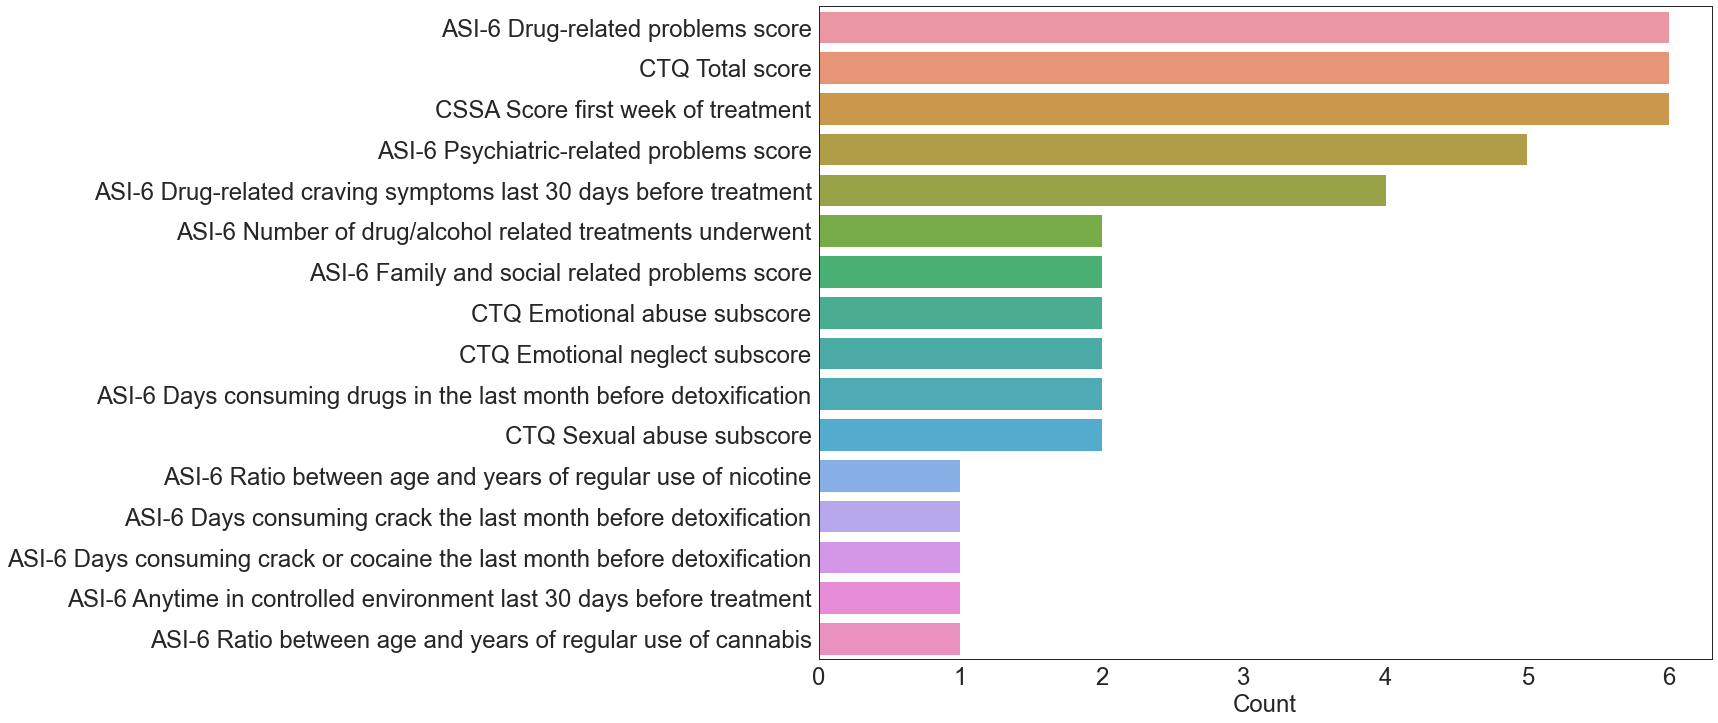

In [23]:
## Make feature counts in models plot ##


## Set parameters for figures
from matplotlib import rcParams
import matplotlib.ticker as ticker

# figure size in inches
rcParams['figure.figsize'] = 16,12
rcParams.update({'font.size': 24})
rcParams['axes.linewidth'] = 1

sns.set_style(style='white')

## Make the variables from each model into a dataframe for ease of manipulation
df_test = pd.DataFrame()
df_test["var"] = variable_names_logreg

## Plot
ax = sns.countplot(y=variable_names_logreg, order = df_test["var"].value_counts().index)

## Set X-axis label
plt.xlabel("Count", horizontalalignment='center')


## Save figure
plt.savefig('../figures/feature_counts.png', dpi=300, transparent=True, bbox_inches="tight")
plt.savefig('../figures/feature_counts.svg', dpi=300, transparent=True, bbox_inches="tight")

plt.show()

In [24]:
## Create CMAP with shap plot colors
from  matplotlib.colors import LinearSegmentedColormap
cmap=LinearSegmentedColormap.from_list('rg',["green", "orange"], N=256) 

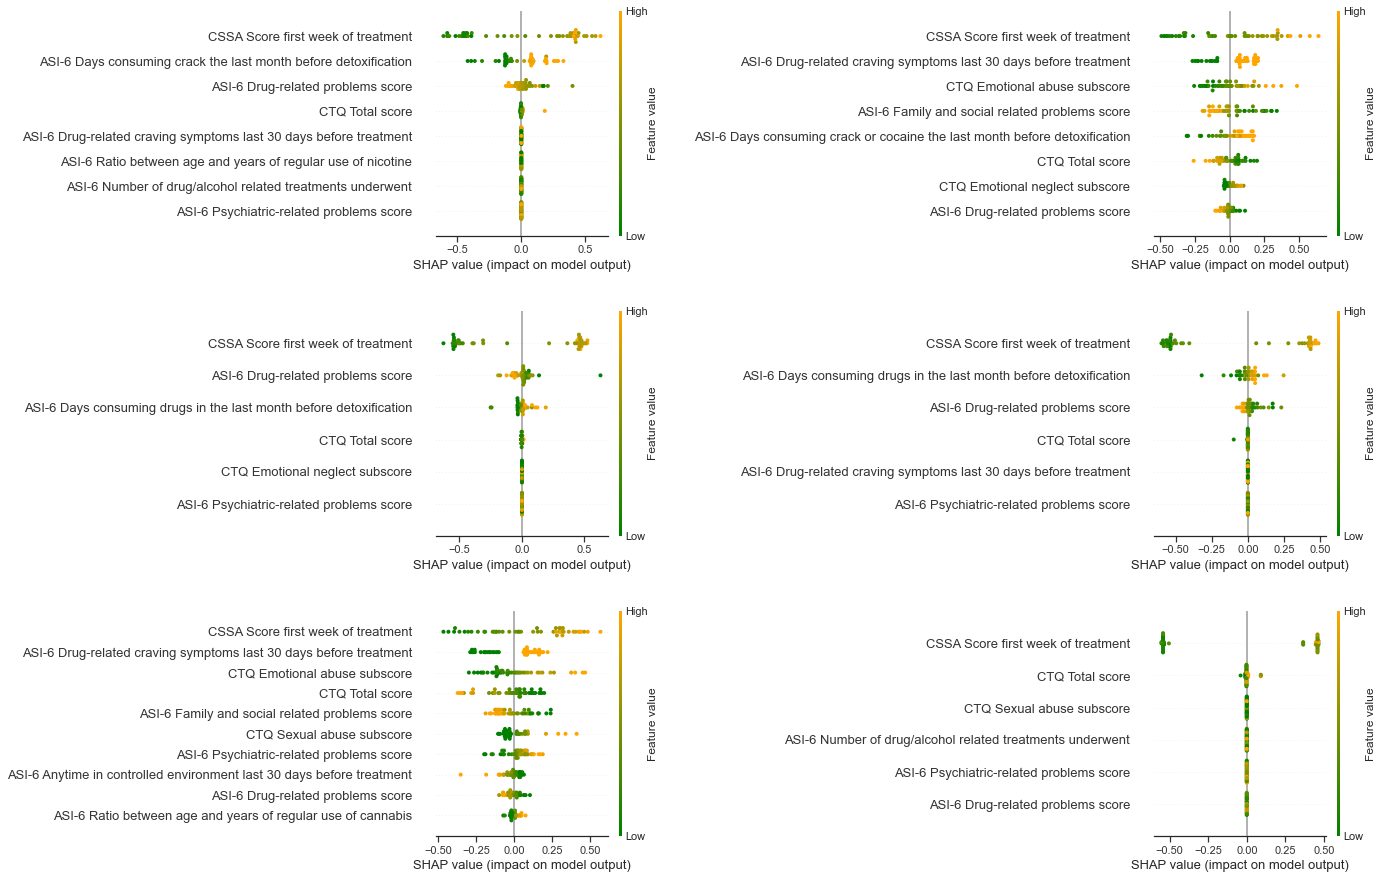

In [35]:
## Plot shap summary plots
rcParams['figure.figsize'] = 20,13
plt.rc('font', size=33)
sns.set_style(style='white')

plt.subplot(3,2, 1)
shap.summary_plot(np.asarray(list_shap_values_cv_0), X_cv_0, show = False, plot_size=None, cmap=cmap)

plt.subplot(3,2,2)
shap.summary_plot(np.asarray(list_shap_values_cv_1), X_cv_1, show = False, plot_size=None, cmap=cmap)

plt.subplot(3,2,3)
shap.summary_plot(np.asarray(list_shap_values_cv_2), X_cv_2, show = False, plot_size=None, cmap=cmap)

plt.subplot(3,2,4)
shap.summary_plot(np.asarray(list_shap_values_cv_3), X_cv_3, show = False, plot_size=None, cmap=cmap)

plt.subplot(3,2,5)
shap.summary_plot(np.asarray(list_shap_values_cv_4), X_cv_4, show = False, plot_size=None, cmap=cmap)


plt.subplot(3,2,6)
shap.summary_plot(np.asarray(list_shap_values_cv_5), X_cv_5, show = False, plot_size=None, cmap=cmap)


## Save figure
plt.savefig('../figures/shap_summary_plot.png', dpi=300, transparent=True, bbox_inches="tight")
plt.savefig('../figures/shap_summary_plot.svg', dpi=300, transparent=True, bbox_inches="tight")

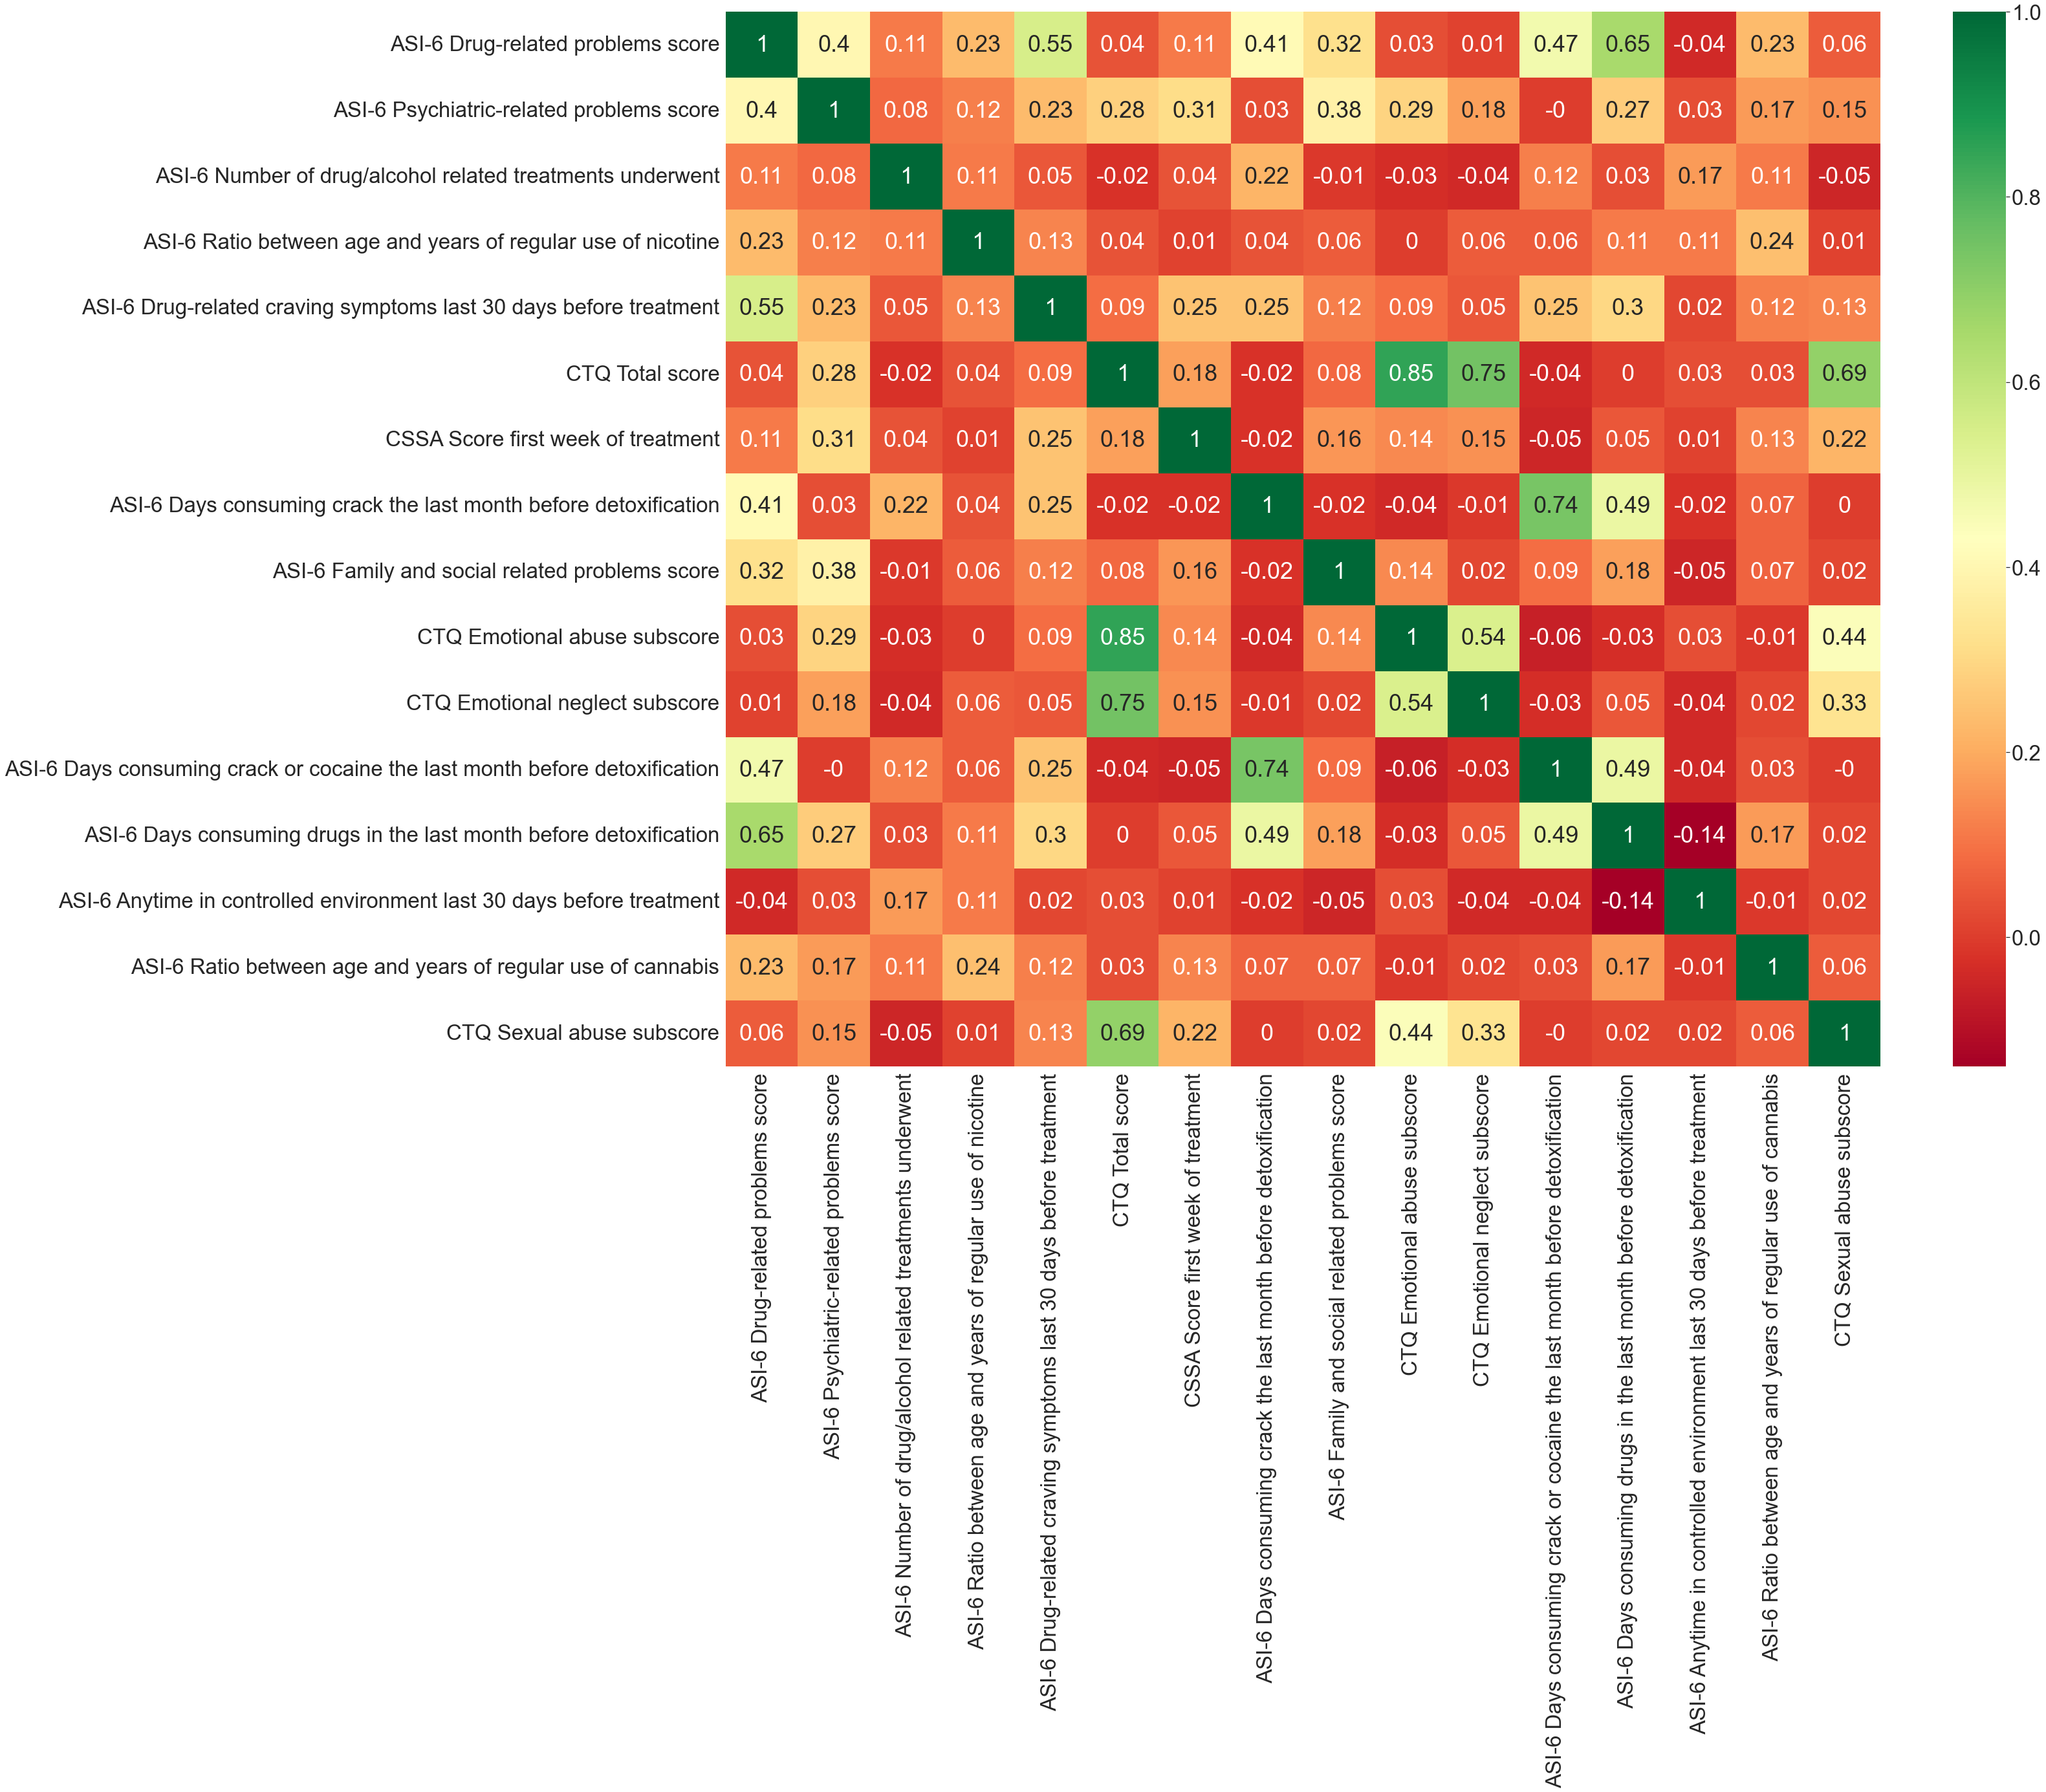

In [26]:
## Make Heatmap for features
corrmat = df.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(40,30))
sns.set(font_scale = 3)

#plot heat map and save it
sns.heatmap(X_original[df_test["var"].unique()].corr().round(2),annot=True,cmap="RdYlGn")


plt.savefig('../figures/correlation_heatmap.png', dpi=300, transparent=True, bbox_inches="tight")
plt.savefig('../figures/correlation_heatmap.svg', dpi=300, transparent=True, bbox_inches="tight")